In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import urllib
import json, h5py
import os, glob
import warpImage
from pointAnnotator import pointAnnotator, pointCopier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook

In [2]:
localWarp=False

#for some reason, I find you have to run this line twice to actually take effect (depending on matplotlib version)
%matplotlib notebook 

In [12]:
#get path to network folder with lims images for this mouse
mouse_num = '484106'
json_string = urllib.urlopen("http://lims2/specimens/isi_experiment_details/" + mouse_num + ".json").read()
info = json.loads(json_string)
vimg_path = r'\\' + info[0]['target_map_image_path'][1:]
print(vimg_path)

\\allen/programs/braintv/production/visualbehavior/prod0/specimen_931903393/isi_experiment_944169299/944169299_target_map.tif


In [13]:
#get vasculature image
vimg = cv2.imread(vimg_path)

#get probe insertion image
pimgFileName = r"Z:\12122019_484106\2019_12_12_18_20_25_left.png"
pimg = cv2.imread(pimgFileName)

#change from opencv bgr default back to rgb
pimg = pimg[:, :, [2,1,0]]
vimg = vimg[:, :, [2,1,0]]
aspect = (pimg.shape[0]+vimg.shape[0])/float(np.max([pimg.shape[1], vimg.shape[1]]))

<IPython.core.display.Javascript object>


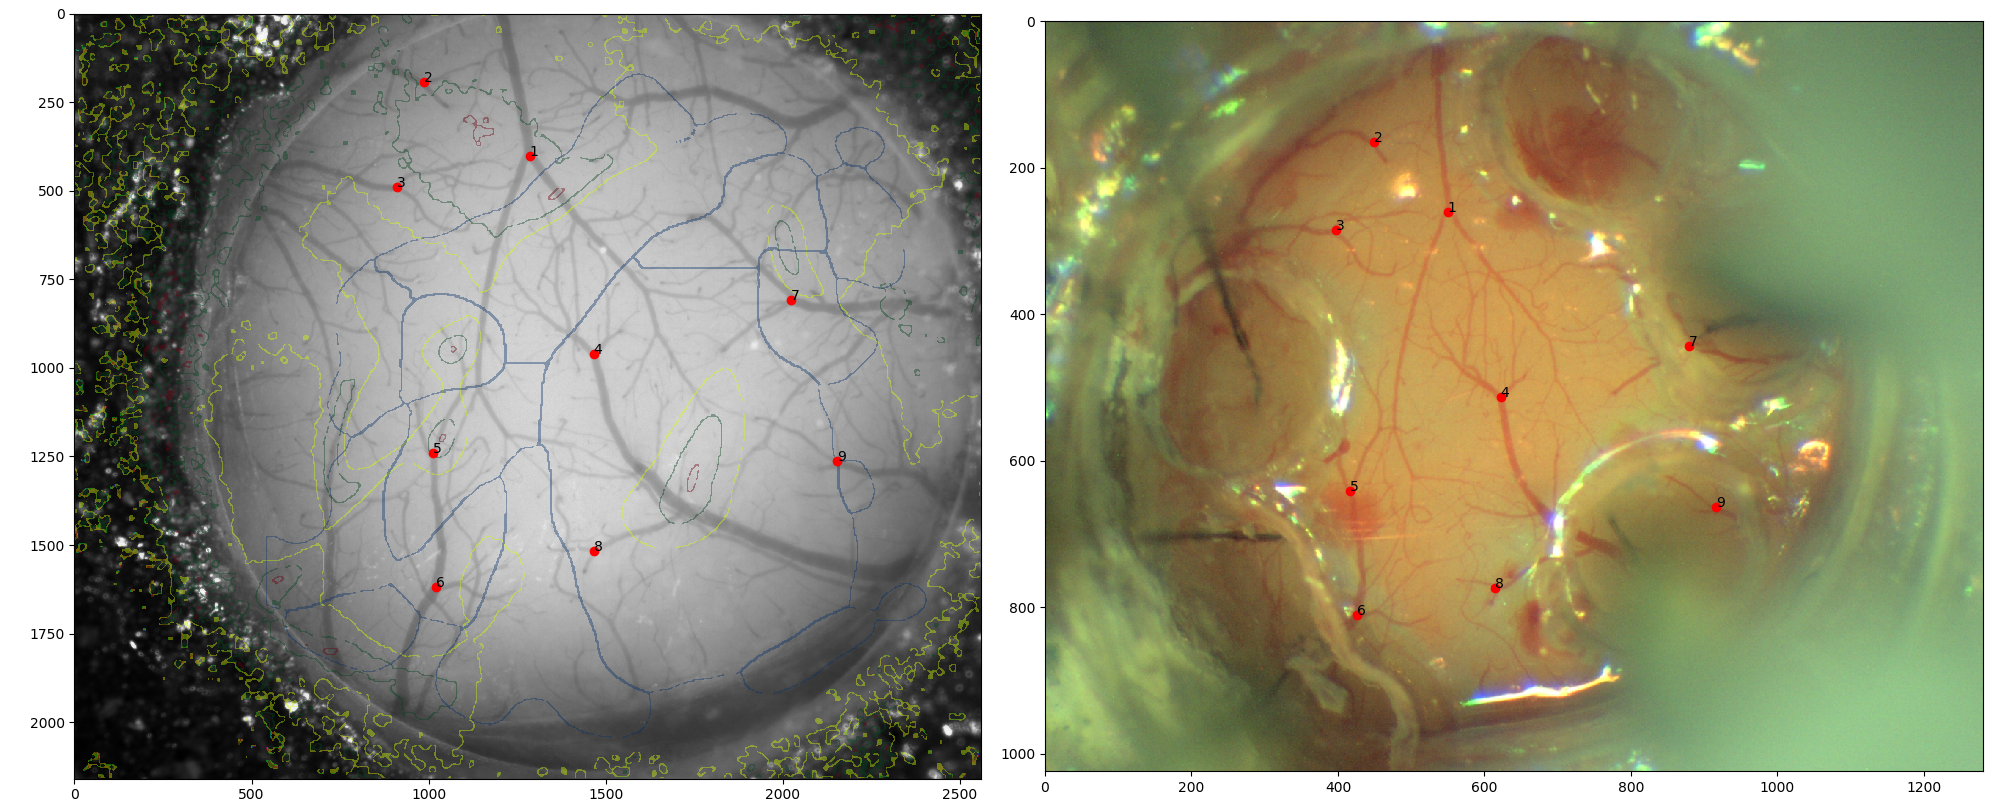

In [14]:
#Display the vasculature image and select points of interest (at least three)
fig, ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
vax = ax[0]
pax = ax[1]

vim = vax.imshow(vimg, origin='upper')
vpa = pointAnnotator(vim, vax)
#vpa.loadPoints(vpoints)

pim = pax.imshow(pimg, origin='upper')
ppa = pointAnnotator(pim, pax)

plt.tight_layout(pad=1, w_pad=0, h_pad=0)

<IPython.core.display.Javascript object>


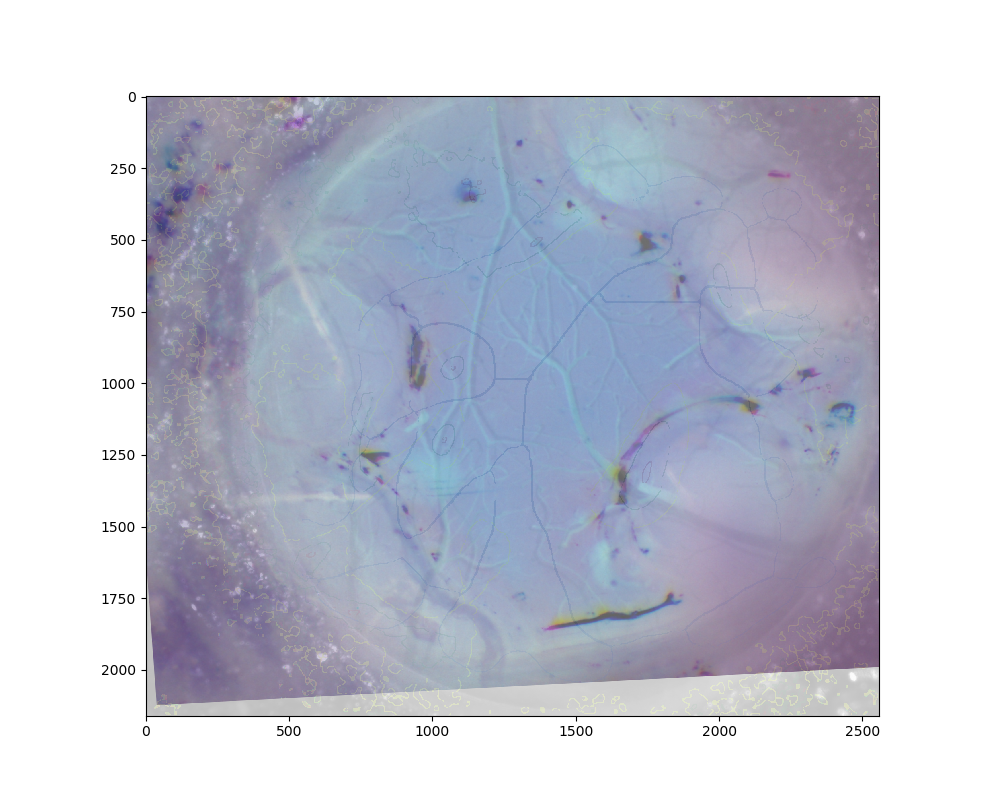

In [15]:
#Compute affine transform to warp probe insertion image to vasculature image coordinates
loadFromFile = False

if loadFromFile:
    #datafile = r"Z:\04252019_421323\ISIregistration.npz"
    datafile = os.path.join(os.path.dirname(pimgFileName), 'ISIregistration.npz')
    data = np.load(datafile)
    ppoints = data['probeImageKeypoints']
    vpoints = data['vasculatureImageKeypoints']

else:  
    #reshape points into [numpoints, 2] arrays
    ppoints = np.stack((ppa.xs, ppa.ys)).astype(np.float32).T
    vpoints = np.stack((vpa.xs, vpa.ys)).astype(np.float32).T

#get perspective transform between images and apply it to probe insertion image
perspective = cv2.findHomography(ppoints, vpoints)
pimg_transform = cv2.warpPerspective(pimg, perspective[0], (vimg.shape[1], vimg.shape[0]))

#transform probe insertion points to use in local warping or plot on transformed image
ppoints_transform = cv2.perspectiveTransform(np.array([ppoints.astype(np.float32)]), perspective[0])
ppoints_transform = np.squeeze(ppoints_transform)

#perform Delaunay triangle local warp if specified
if localWarp:
    pimg_transform = warpImage.warpImage(vimg, pimg_transform, vpoints, ppoints_transform)

#plot overlay of vasculature image and transformed image to compare
fig, ax = plt.subplots(figsize=(10,10/aspect))
ax.imshow(vimg, alpha=0.5)
ax.imshow(255-pimg_transform, alpha=0.5)


<IPython.core.display.Javascript object>


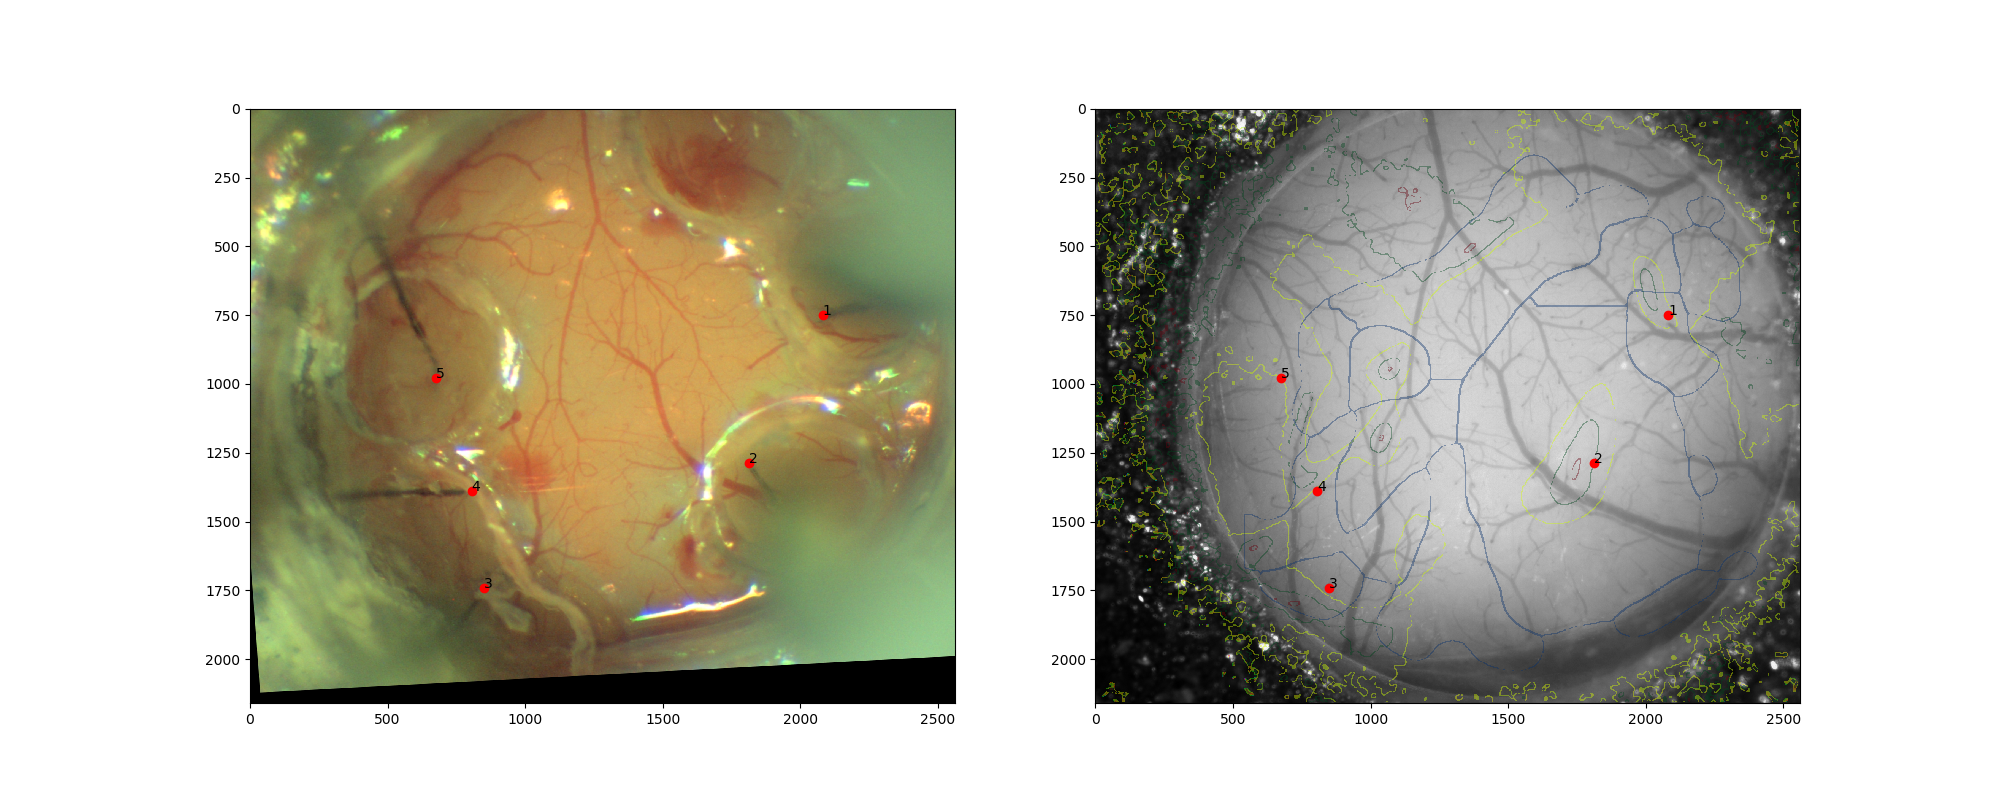

In [16]:
#Select location of probe insertion points in this warped image
fig, ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
paffax = ax[0]
vax2 = ax[1]

paff_im = paffax.imshow(pimg_transform, origin='upper')
paffp = pointAnnotator(paff_im, paffax)
paffpoints = np.stack((paffp.xs, paffp.ys)).astype(np.float32).T

vim2 = vax2.imshow(vimg, origin='upper')
vpa = pointCopier(vim2, vax2)

In [10]:
# save points and transformation matrix
saveDirectory = os.path.dirname(pimgFileName)
np.savez(os.path.join(saveDirectory, 'ISIregistration.npz'), vasculatureImageKeypoints=vpoints, probeImageKeypoints=ppoints, vasculatureToProbeInsertionTransform=perspective[0], probeInsertionPointsTransformed=paffpoints)

In [11]:
# save notebook as html
saveDirectory = os.path.dirname(pimgFileName)
os.system('jupyter nbconvert probeInsertionLocator.ipynb --output ' + os.path.join(saveDirectory, 'probeInsertionNotebook.html'))

0

In [24]:
nwbFile = glob.glob(os.path.join(os.path.dirname(vimg_path), '*nwb'))
nwb = h5py.File(nwbFile)

[u'\\\\allen/programs/braintv/production/visualbehavior/prod0/specimen_769292015/isi_experiment_777042004\\777042004.nwb']


In [22]:
info[0]

{u'external_specimen_name': u'421323',
 u'id': u'769292015',
 u'isi_experiments': [{u'id': u'777042004',
   u'name': u'20181112_421323',
   u'project_code': u'NeuropixelVisualBehaviorDevelopment',
   u'targets': {u'actual_insertion': {u'image_space': [{u'x': 1792.0,
       u'y': 384.0},
      {u'x': 1928.0, u'y': 776.0},
      {u'x': 1416.0, u'y': 1316.0},
      {u'x': 836.0, u'y': 1240.0},
      {u'x': 708.0, u'y': 852.0},
      {u'x': 1280.0, u'y': 556.0}],
     u'reticle_space': [{u'x': 1125.67, u'y': -1458.47},
      {u'x': 1419.23, u'y': -567.88},
      {u'x': 243.3, u'y': 634.4},
      {u'x': -1064.68, u'y': 442.3},
      {u'x': -1340.3, u'y': -438.97},
      {u'x': -37.35, u'y': -1087.77}]},
    u'insertion_targets': {u'image_space': [{u'x': 1792.0, u'y': 516.0},
      {u'x': 1880.0, u'y': 744.0},
      {u'x': 1388.0, u'y': 1288.0},
      {u'x': 776.0, u'y': 1228.0},
      {u'x': 764.0, u'y': 896.0},
      {u'x': 1276.0, u'y': 528.0}],
     u'reticle_space': [{u'x': 1121.04, u'y